In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="flovYxnQFrP7nIyGjxVM")
project = rf.workspace("thesis-karin").project("lane-classification-bbdg0")
dataset = project.version(1).download("folder")

     |████████████████████████████████| 145 kB 15.3 MB/s 
     |████████████████████████████████| 178 kB 62.5 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 138 kB 65.7 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Lane-Classification-1 in folder:: 100%|██████████| 6974/6974 [00:03<00:00, 1800.21it/s]


In [3]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [4]:
device = get_default_device()
device

device(type='cuda')

In [5]:
#train and test data directory
data_dir = "/content/Lane-Classification-1/train"
test_data_dir = "/content/Lane-Classification-1/test"
valid_data_dir = "/content/Lane-Classification-1/valid"

#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
valid_dataset = ImageFolder(valid_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [6]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [7]:

print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['0 Solid-Solid', '1 Solid-Dash', '2 Dash-Solid', '3-Dash', '4-Solid']


In [8]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

Label : 0 Solid-Solid


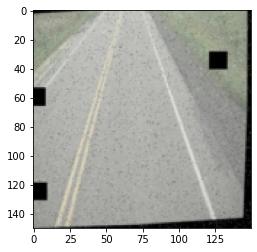

In [9]:

def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

train_dl = DeviceDataLoader(DataLoader(dataset, 32, shuffle = True, num_workers = 2, pin_memory = True), device)
val_dl = DeviceDataLoader(DataLoader(valid_dataset, 32*2, num_workers = 2, pin_memory = True), device)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class myClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [13]:
class resNetClassification(ImageClassificationBase):
    def __init__(self, base_model, base_out_features, num_classes):
        super(resNetClassification,self).__init__()
        self.base_model = base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
        
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

resNet = torchvision.models.resnet50(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [15]:
model = myClassification()
model = model.to(device)
model

myClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fe

In [16]:
model1 = resNetClassification(base_model=resNet, base_out_features=resNet.fc.out_features, num_classes=5)
model1 = model1.to(device)
model1

resNetClassification(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [17]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [18]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [19]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.4781, val_loss: 1.5656, val_acc: 0.2486
Epoch [1], train_loss: 1.4165, val_loss: 1.4385, val_acc: 0.2614
Epoch [2], train_loss: 1.3881, val_loss: 1.2766, val_acc: 0.3991
Epoch [3], train_loss: 1.3649, val_loss: 1.2507, val_acc: 0.3371
Epoch [4], train_loss: 1.3105, val_loss: 1.1845, val_acc: 0.4882
Epoch [5], train_loss: 1.2836, val_loss: 1.3070, val_acc: 0.4081
Epoch [6], train_loss: 1.2157, val_loss: 1.0433, val_acc: 0.5810
Epoch [7], train_loss: 1.1536, val_loss: 1.0189, val_acc: 0.5672
Epoch [8], train_loss: 0.9755, val_loss: 0.5355, val_acc: 0.7666
Epoch [9], train_loss: 0.6339, val_loss: 0.4405, val_acc: 0.7642
Epoch [10], train_loss: 0.4847, val_loss: 0.3368, val_acc: 0.8139
Epoch [11], train_loss: 0.4189, val_loss: 0.3504, val_acc: 0.8182
Epoch [12], train_loss: 0.3750, val_loss: 0.3262, val_acc: 0.8267
Epoch [13], train_loss: 0.3411, val_loss: 0.2696, val_acc: 0.8651
Epoch [14], train_loss: 0.2879, val_loss: 0.2886, val_acc: 0.8452


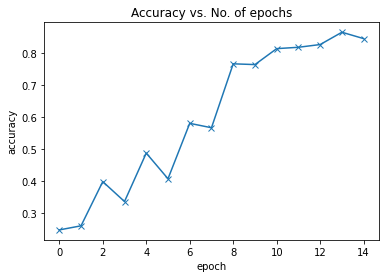

In [20]:
plot_accuracies(history)

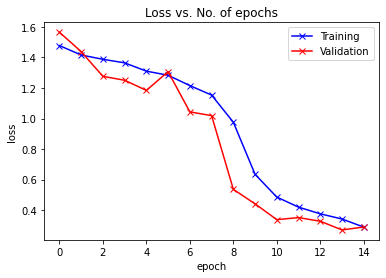

In [21]:
plot_losses(history)

In [22]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model1, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5426, val_loss: 0.5115, val_acc: 0.7112
Epoch [1], train_loss: 0.3591, val_loss: 0.5720, val_acc: 0.7599
Epoch [2], train_loss: 0.2812, val_loss: 2.0347, val_acc: 0.5810
Epoch [3], train_loss: 0.1823, val_loss: 0.1473, val_acc: 0.9702
Epoch [4], train_loss: 0.1200, val_loss: 0.0376, val_acc: 0.9858
Epoch [5], train_loss: 0.0719, val_loss: 0.0119, val_acc: 0.9986
Epoch [6], train_loss: 0.0695, val_loss: 0.0548, val_acc: 0.9872
Epoch [7], train_loss: 0.0694, val_loss: 0.0258, val_acc: 0.9901
Epoch [8], train_loss: 0.0789, val_loss: 0.0165, val_acc: 0.9943
Epoch [9], train_loss: 0.0594, val_loss: 0.0303, val_acc: 0.9943
Epoch [10], train_loss: 0.0397, val_loss: 0.0703, val_acc: 0.9815
Epoch [11], train_loss: 0.0584, val_loss: 0.0196, val_acc: 0.9957
Epoch [12], train_loss: 0.0377, val_loss: 0.0082, val_acc: 0.9986
Epoch [13], train_loss: 0.0225, val_loss: 0.0186, val_acc: 0.9943
Epoch [14], train_loss: 0.0499, val_loss: 0.8517, val_acc: 0.7514


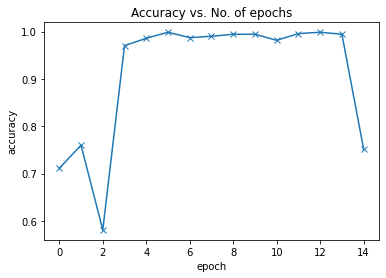

In [23]:
plot_accuracies(history)

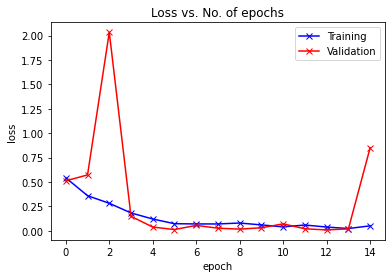

In [24]:
plot_losses(history)

In [25]:
torch.save(model.state_dict(), 'lane-classification.pth')
torch.save(model1.state_dict(), 'lane-classification-res.pth')